In [49]:
import fact.io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u


from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.stats import binned_statistic
from sklearn.ensemble import RandomForestRegressor


from spectrum import make_energy_bins

from tqdm import tqdm
%matplotlib inline

In [50]:
def plot_energy_resolution(e_true, e_reco, bins, ax=None, color='crimson'):
    if not ax :
        ax = plt.gca()
    resolution = (e_reco) / e_true

    iqr, bin_edges, binnumber = binned_statistic(e_reco, resolution, statistic=lambda y: ((np.percentile(y, 84) - np.percentile(y, 16)) / 2), bins=bins)

    label = '$IQR_{68}$ of $\\frac{E_R - E_T}{E_T}$'

    ax.hlines(iqr, bins[:-1], bins[1:], lw=2, color=color, label=label)

    path = '../resources/CTA-Performance-prod3b-v1-South-20deg-50h-Eres.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=11, names=['energy', 'resolution'], engine='python')
    ax.plot(df.energy, df.resolution, '--', color='#5b5b5b', label='Prod3B Reference')


    ax.set_xscale('log')

    ax.set_ylabel(label)
    ax.set_xlabel(r'$True Energy /  \mathrm{TeV}$')
    return ax

def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

In [51]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'

e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['run_id', 'array_event_id', 'gamma_prediction_mean', 'gamma_energy_prediction_mean',
           'az_prediction', 'alt_prediction', 'mc_energy', 'num_triggered_telescopes']
gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns, ).set_index(['run_id', 'array_event_id'])
gammas = gammas.dropna()
gammas['theta'] = calculate_theta(gammas)

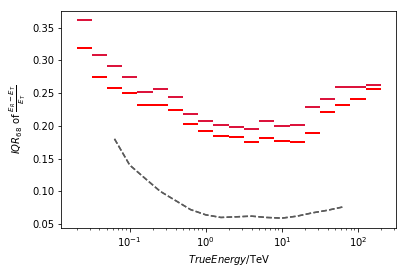

In [52]:
plot_energy_resolution(gammas.mc_energy, gammas.gamma_energy_prediction_mean, bins=bin_edges, color='crimson')

m = (gammas.gamma_prediction_mean > 0.8) & (gammas.theta < 0.2)
plot_energy_resolution(gammas[m].mc_energy, gammas[m].gamma_energy_prediction_mean, bins=bin_edges, color='red')


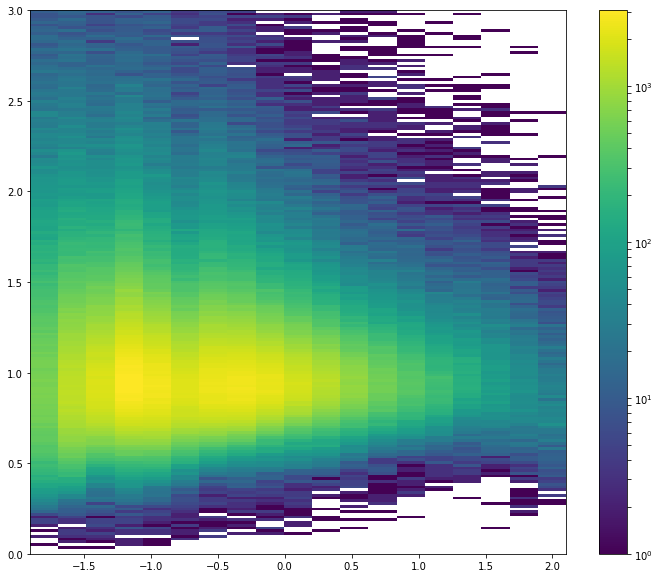

In [53]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(12, 10))
bins_y = np.linspace(0, 3, 200)
bins_x = np.linspace(-1.9, 2.1, 20)
plt.hist2d(np.log10(gammas.gamma_energy_prediction_mean), gammas.gamma_energy_prediction_mean/gammas.mc_energy, bins=[bins_x, bins_y], norm=LogNorm())
plt.colorbar()
None

In [54]:
columns = [ 'array_event_id', 'distance_to_core', 'gamma_energy_prediction', 'gamma_prediction',
            'intensity', 'kurtosis', 'length', 'phi', 'r', 'run_id',
            'skewness','telescope_type_id', 'telescope_type_name', 'width']
gamma_tel_events = fact.io.read_data(gamma_input, key='telescope_events', columns=columns)
gamma_tel_events = gamma_tel_events.dropna()

In [55]:
columns = ['gamma_energy_prediction', 'gamma_prediction']
keys = [ 'run_id', 'array_event_id', 'telescope_type_name']
nested_features = gamma_tel_events.groupby(keys)[columns].agg([np.sum, np.mean, np.std, np.max, np.min, np.median])
nested_features = nested_features.fillna(0).unstack(level=-1, fill_value=-1)
feature_names = ['_'.join(col).strip() for col in nested_features.columns.values]
nested_features.columns = feature_names

In [56]:
gammas_merged = gammas.merge(nested_features, left_index=True, right_index=True, ).reset_index()

In [57]:
ids = gammas_merged.run_id.unique()
sample_ids = np.random.choice(ids, size=len(ids) // 10)
train_sample = gammas_merged[gammas_merged.run_id.isin(sample_ids)]

cols = ['run_id', 'array_event_id', 'theta', 'az_prediction', 'alt_prediction', 'mc_energy',]
X = train_sample.drop(columns=cols).values
y = train_sample.mc_energy.values

In [58]:
print(X.shape, y.shape)
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=6, n_jobs=20, max_features='sqrt')
rf.fit(X, y)

(93318, 39) (93318,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=20,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [59]:
e_reco = rf.predict(gammas_merged.drop(columns=cols).values)

In [60]:
# gamma_tel_events.set_index(['run_id', 'array_event_id'])
df = gamma_tel_events.set_index(['run_id', 'array_event_id']).merge(gammas, left_index=True, right_index=True)
len(df)

4882167

(0, 0.45)

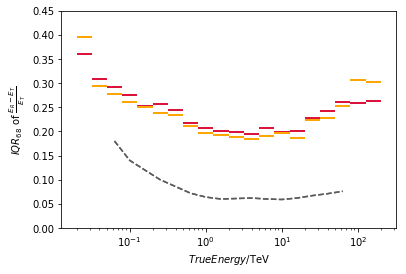

In [61]:
ax = plot_energy_resolution(gammas.mc_energy, gammas.gamma_energy_prediction_mean, bins=bin_edges, color='crimson')
plot_energy_resolution(gammas_merged.mc_energy, e_reco, bins=bin_edges, ax=ax, color='orange')
ax.set_ylim([0, 0.45])
# plot_energy_resolution(gammas.mc_energy, gammas.mc_energy + np.random.normal(size=len(gammas)) * 0.01, bins=bin_edges, ax=ax, color='blue')

(0, 0.45)

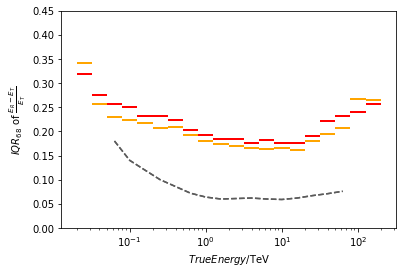

In [62]:
plt.figure()

m = (gammas_merged.gamma_prediction_mean > 0.8) & (gammas_merged.theta < 0.2)

ax = plot_energy_resolution(gammas_merged[m].mc_energy, gammas_merged[m].gamma_energy_prediction_mean, bins=bin_edges, color='red')
plot_energy_resolution(gammas_merged[m].mc_energy, e_reco[m], bins=bin_edges, ax=ax, color='orange')
ax.set_ylim([0, 0.45])

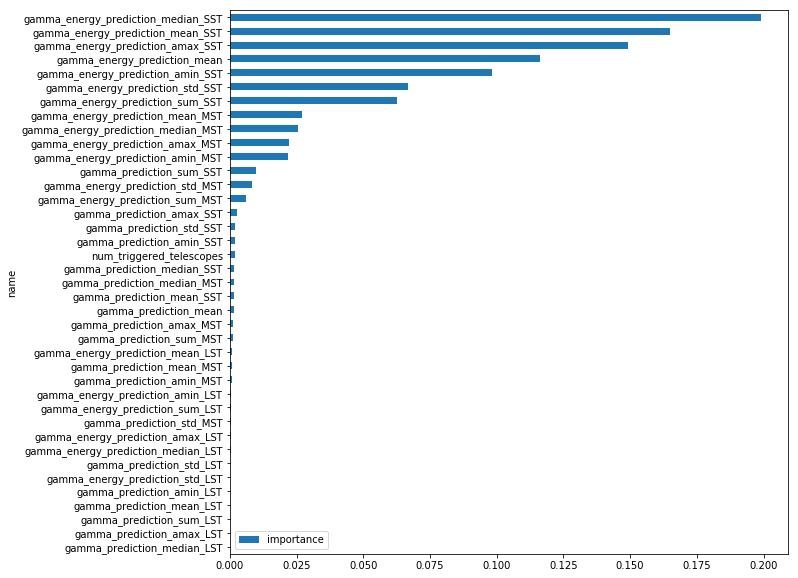

In [63]:
df = pd.DataFrame({'importance': rf.feature_importances_ , 'name':gammas_merged.drop(columns=cols).columns.values})
df.index = df.name
df = df.sort_values(by='importance', ascending=True)
df.plot.barh(figsize=(10, 10))